# Фукнции необходимые для прямого и обратного прохода в сверточных нейросетях

## Взаимнокорреляционная функция

In [31]:
# для большинства преобразований
import numpy as np
# для более быстрой реализации операций кросс-корреляции и свертки
from scipy import signal

Взаимнокорреляционная функция или кросс-корреляция (/взаимная операция корреляция), операция обозначается символом **$\star$**  (закрашенная звездочка)

In [32]:
from scipy import signal
import numpy as np

input = np.array([[1, 6, 2],
                 [5, 3, 1],
                 [7, 0, 4]])
kernel = np.array([[1, 2],
                   [-1, 0]])

signal.correlate2d(input, kernel, 'valid')

array([[8, 7],
       [4, 5]])

In [33]:
from scipy import signal

input = np.array([[1, 6, 2],
                 [5, 3, 1],
                 [7, 0, 4]])
kernel = np.array([[1, 2],
                   [-1, 0]])

signal.correlate2d(input, kernel, 'full')

array([[ 0, -1, -6, -2],
       [ 2,  8,  7,  1],
       [10,  4,  5, -3],
       [14,  7,  8,  4]])

## Операция свертки

Операция свертки - все то же, но ядро развернуто на 180°

Обозначается символом **$\ast$**  (звездочка)

In [34]:
from scipy import signal

input = np.array([[1, 6, 2],
                 [5, 3, 1],
                 [7, 0, 4]])
kernel = np.array([[1, 2],
                   [-1, 0]])

signal.convolve2d(input, kernel, 'full')

array([[ 1,  8, 14,  4],
       [ 4,  7,  5,  2],
       [ 2, 11,  3,  8],
       [-7,  0, -4,  0]])

# Выпрямление

In [35]:
'''
Модуль "выпрямления"
подробнее см. https://youtu.be/Lakz2MoHy6o?t=1648
На основе формы входного и выходного тензора выпрямляет вход при прямом проходе и градиент при обратном проходе
'''
class Reshape():
    '''
    input_shape: форма входного тензора
    output_shape: форма выходного тензора
    '''
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
    '''
    input - np.array входной вектор данных
    преобразует входные данные из (формы входа) в (форму выхода)
    '''
    def forward(self, input):
        return np.reshape(input, self.output_shape)

    # преобразует градиент из в размер (формы выхода)
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

# Активации

## Сигмоидальная

In [36]:
'''
Класс сигмоидальной активации
Реализует прямой и обратный проход
На основе https://youtu.be/Lakz2MoHy6o?t=1791
'''
class Sigmoid():
    # прямой проход по формуле сигмоиды
    # сохраняем вход для расчета вектора градиента по нему
    def forward(self, x):
        self.input = x
        return 1 / (1 + np.exp(-x))

    '''
    output gradient - np.array вектор градиента распространенный от слов перед ним
    learning_rate - float скорость обучения
    '''
    def backward(self, output_gradient, learning_rate):
        s = self.forward(self.input)
        # вывод производной сигмоиды https://hausetutorials.netlify.app/posts/2019-12-01-neural-networks-deriving-the-sigmoid-derivative/#:~:text=The%20derivative%20of%20the%20sigmoid%20function%20%CF%83(x)%20is%20the,1%E2%88%92%CF%83(x).
        sigmoid_grad = s * (1 - s)
        # градиент от поэлементной функциии (любая активация) - диагональная
        # можем просто засунуть выходной градиент в производную от заданной функции активации
        # (почему это так см. https://youtu.be/pauPCy_s0Ok?t=1248)
        return np.multiply(output_gradient, sigmoid_grad)

## Функция активации гиперболический тангенс

In [37]:
'''
Класс активации гиперболического тангенса
Реализует прямой и обратный проход
подробнее см. https://youtu.be/pauPCy_s0Ok?t=1350
'''
class Tanh():
    # прямой проход по формуле гиперболического тангенса
    # сохраняем вход для расчета вектора градиента по нему
    def forward(self, x):
        self.input = x
        return np.tanh(x)
    '''
    output gradient - np.array вектор градиента распространенный от слов перед ним
    learning_rate - float скорость обучения
    '''
    def backward(self, output_gradient, learning_rate):
        # вывод производной гиперболического тангенса
        # https://stackoverflow.com/questions/62634073/why-gradient-of-tanh-in-tensorflow-is-grad-dy-1-yy
        tanh_grad = 1 - np.tanh(self.input) ** 2
        # почему так см. примечания сигмоды
        return np.multiply(output_gradient, tanh_grad)

## Функция активации softmax

In [38]:
'''
Класс активации софтмакса
Реализует прямой и обратный проход
На основе https://youtu.be/AbLvJVwySEo
'''
class Softmax():
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output

    def backward(self, output_gradient, learning_rate):
        # размер входа
        n = np.size(self.output)
        # см. на основе или https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

# Бинарная кросс-энтропия

In [39]:
'''
Формула бинарной кросс энтропии справедлива если
целевая переменная 1 или 0
Фукнции прямого и обратного прохода вынесены
в отдельные модули для более ясного выделения градиента
и его отправки в backward методы прочих активаций и слоев
На основе https://youtu.be/Lakz2MoHy6o?t=1674
'''
def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))
# градиент по бинарной кросс-энтропии, см https://youtu.be/Lakz2MoHy6o?t=1674
def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

# Классы слоев

## Полносвязный слой

In [40]:
'''
Класс полносвязного слоя
Реализует прямой и обратный проход
На основе https://youtu.be/Lakz2MoHy6o
'''
class Dense():
    '''
    Конструктор класса инициализирует веса слоя
    input_shape: typle - форма входного тензора
    output_shape: typle - форма выходного тензора
    '''
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
    '''
    input: входные данные (вектор)
    Прямой проход - действие матрицы весов на входные данные y = WX + b
    '''
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias
    '''
    output gradient - np.array вектор градиента распространенный от слов перед ним
    learning_rate - float скорость обучения
    Реализует обратный проход по полносвязному слою, находя производные
    по входам (чтобы распространить сигнал потерь в предшествующие слои), весам слоя и смещениям
    На основе https://youtu.be/pauPCy_s0Ok?t=1102
    '''
    def backward(self, output_gradient, learning_rate):
        # производная по весам слоя - скаляреное произведелние между гражиентов слоя перед
        # и транспонированным входом (см. https://youtu.be/pauPCy_s0Ok?t=683)
        weights_gradient = np.dot(output_gradient, self.input.T)
        # градиент по входам - скалярное между транспонированными весами и градиентов слоя перед
        # необходим, чтобы рассчитать градиент более ранних слоев
        # (см. https://youtu.be/pauPCy_s0Ok?t=988)
        input_gradient = np.dot(self.weights.T, output_gradient)
        # шаг град спуска
        self.weights -= learning_rate * weights_gradient
        # градиент по смещениям = градиента слоя перед (см. https://youtu.be/pauPCy_s0Ok?t=899)
        # делаем шаг по минус градиенту с заданной скоростью
        self.bias -= learning_rate * output_gradient
        # возвращаем градиент по входам для распространения сигнала градиента в предшествующие слои
        return input_gradient

## Сверточный слой

In [ ]:
'''
Класс сверточного слоя
Реализует прямой и обратный проход
На основе https://youtu.be/Lakz2MoHy6o
'''
class Convolutional():
    '''
    Конструктор класса инициализирует веса слоя
    input_shape: typle - форма входного тензора (например картинка 1*28*28) - глубина, высота, ширина
    kernel_size: int - размер квадратного ядра свертки
    depth: int - количество выходных каналов == количество карт активаций == количество сверточных нейронов
    '''
    def __init__(self, input_shape, kernel_size, depth):
        # распаковываем входную форму на глубину (кол-во входных каналов), высоту и ширину изображения / карт активаций прошлых сверточных слоев
        input_depth, input_height, input_width = input_shape
        # количество выходных каналов == количество карт активаций == количество сверточных нейронов
        self.depth = depth
        # размер входных данных
        self.input_shape = input_shape
        # количество каналов на вход
        self.input_depth = input_depth
        # форма выходных карт активации (с учетом размера ядра)
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        # размер ядра
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        # случайные значения - веса сверточных нейронов слоя
        self.kernels = np.random.randn(*self.kernels_shape)
        # случайные значения - смещения
        self.biases = np.random.randn(*self.output_shape)

    '''
    input: входные данные (вектор)
    Прямой проход - действие матрицы весов на входные данные y = W*X + b
    Только вместо скаляров в W стоят ядра свертки (i) для каждого канала (j)
    Вместо x стоят входные данные (j входных каналов)
    Вместо произведения * стоит кросс корреляция valid
    '''
    def forward(self, input):
        # сохраняем входы и выходы для вычисления градиента по слою после
        self.input = input
        self.output = np.copy(self.biases)
        # итерируемся по всем сверточным нейронам слоя (количество карт активаций)
        for i in range(self.depth):
            # итерируемся по всех входам (каналам)
            for j in range(self.input_depth):
                # valid кросс-корреляция
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    '''
    output gradient - np.array вектор градиента распространенный от слов перед ним
    learning_rate - float скорость обучения
    Реализует обратный проход по сверточному слою, находя производные
    по входам (чтобы распространить сигнал потерь в предшествующие слои), весам слоя и смещениям
    На основе https://youtu.be/Lakz2MoHy6o?t=1424
    '''
    def backward(self, output_gradient, learning_rate):
        # инициализируем нулями градиенты по ядрам свертки и входам
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)
        # итерируемся по всем сверточным нейронам слоя (количество карт активаций)
        for i in range(self.depth):
            # итерируемся по всех входам
            for j in range(self.input_depth):
                # находим производные по весам см. https://youtu.be/Lakz2MoHy6o?t=828
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                # находим производные по входам см. https://youtu.be/Lakz2MoHy6o?t=1202
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        # делаем шаг по минус градиенту с заданной скоростью
        self.kernels -= learning_rate * kernels_gradient
        # градиент по смещениям = градиента слоя перед (см. https://youtu.be/Lakz2MoHy6o?t=1094)
        # делаем шаг по минус градиенту с заданной скоростью
        self.biases -= learning_rate * output_gradient
        # возвращаем градиент по входам для распространения сигнала градиента в предшествующие слои
        return input_gradient

In [41]:
pip install np_utils

# Фукнция подготовки данных

In [42]:
from keras.datasets import mnist
import np_utils
#from keras.utils import np_utils
#from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical

'''
Ограничиват данные только двумя классами MNIST, создавая подвыборку
'''
def preprocess_data(x, y, limit):
    # находит индексы класса 0 в выборке, обрезает под заданный размер подвыборки
    zero_index = np.where(y == 0)[0][:limit]
    # находит индексы класса 1 в выборке, обрезает под заданный размер подвыборки
    one_index = np.where(y == 1)[0][:limit]
    # собирает их вместе
    all_indices = np.hstack((zero_index, one_index))
    # перемешивает
    all_indices = np.random.permutation(all_indices)
    # выбирает их из всего набора
    x, y = x[all_indices], y[all_indices]
    # переформатирует под размер изображения
    x = x.reshape(len(x), 1, 28, 28)
    # нормализует путем /255 т.к. яркости - int от 0 до 255
    x = x.astype("float32") / 255
    # создает one-hot encoding ответов для соответсвия размера выходов вектора бинарной CE
    # 0 -> [1, 0], 1 -> [0, 1]
    #y = np_utils.to_categorical(y)
    y = to_categorical(y)
    # dense ожидает не 0, 1, 2 а one-hot encoding ответов
    y = y.reshape(len(y), 2, 1)
    return x, y

# загржает MNIST из keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 2000)
x_test, y_test = preprocess_data(x_test, y_test, 2000)

In [43]:
# форма train
x_train.shape, y_train.shape

((4000, 1, 28, 28), (4000, 2, 1))

In [44]:
# форма test
x_test.shape, y_test.shape

((2115, 1, 28, 28), (2115, 2, 1))

# Функция обучения

In [45]:

def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

'''
Функция тренировки
network - список из самописных слоев с прямым (forward) и обратным проходом
loss - функция прямого (forward) прохода функции потерь (принимает на вектора ответов и прогнозов)
loss_prime - функция обратного  (backward) прохода функции потерь (принимает на вектора ответов и прогнозов)
x_train - входные данные (изображения)
у_train - ответы (one-hot вектора для классификации)
epoch - количество эпох (полного показывания всех точек данных)
learning_rate - скорость обучения
verbose - отображать ли loss при обучении
'''
def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    # итерируемся по всем эпохам
    for e in range(epochs):
        # считаем ошибку
        error = 0
        # распаковываем картинки и их one-hot ответы
        for x, y in zip(x_train, y_train):
            # прямой проход
            output = predict(network, x)
            # значения функции потерь
            error += loss(y, output)
            # градиент функции потерь
            grad = loss_prime(y, output)
            # идет от выходов к входам
            for layer in reversed(network):
                # вызывая метод backward каждого элемента, подавая градиент по входам с прошлых шагов
                # на первом шаге это градиент функции потерь
                grad = layer.backward(grad, learning_rate)
        # усредняем ошибку для всей эпохи
        error /= len(x_train)
        # отображаем, если включено
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

# Инициализация сети и обучение

In [46]:
# инициализируем двуслойную сверточную нейросеть
network = [
    Convolutional((1, 28, 28), 3, 10),
    Tanh(),
    Convolutional((10, 26, 26), 3, 5),
    Tanh(),
    Reshape((5, 24, 24), (5 * 24 * 24, 1)),
    Dense(5 * 24 * 24, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

# вызываем функцию обучени
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=5,
    learning_rate=0.003
)

1/5, error=0.15973065848206616
2/5, error=0.02942986833686268


KeyboardInterrupt: 

In [ ]:
x_test[:2]

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)

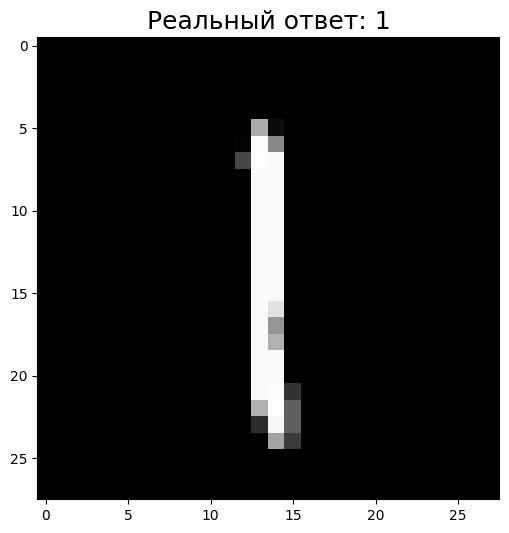

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.title(f'Реальный ответ: {np.argmax(y_test[0])}', fontdict={'fontsize':18})
plt.imshow(x_test[0].reshape((28, 28)), cmap='gray')

In [ ]:
y_test[:2]

array([[[0.],
        [1.]],

       [[1.],
        [0.]]])

In [ ]:
x_test[:2].shape

(2, 1, 28, 28)

In [ ]:
preds = [predict(network, x_test[i]) for i in range(len(x_test))]
np.array(preds).shape

(2115, 2, 1)

In [ ]:
preds = np.argmax(np.array(preds), axis=1)
preds.shape

(2115, 1)

In [ ]:
real = np.argmax(y_test, axis=1)
real.shape

(2115, 1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(real, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      1.00      1.00      1135

    accuracy                           1.00      2115
   macro avg       1.00      1.00      1.00      2115
weighted avg       1.00      1.00      1.00      2115



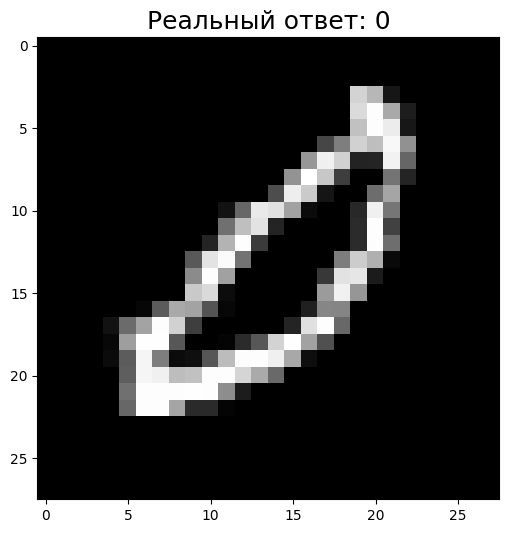

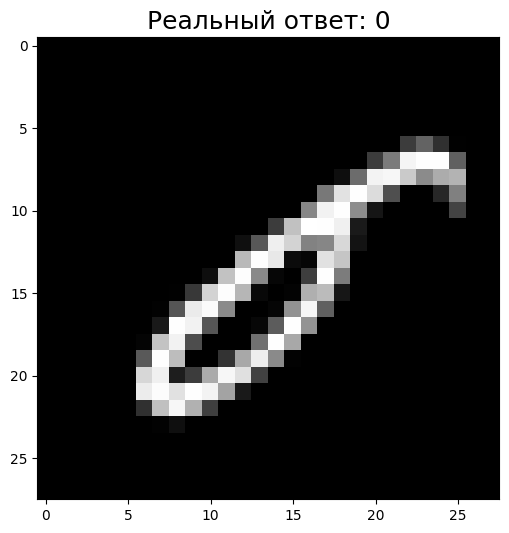

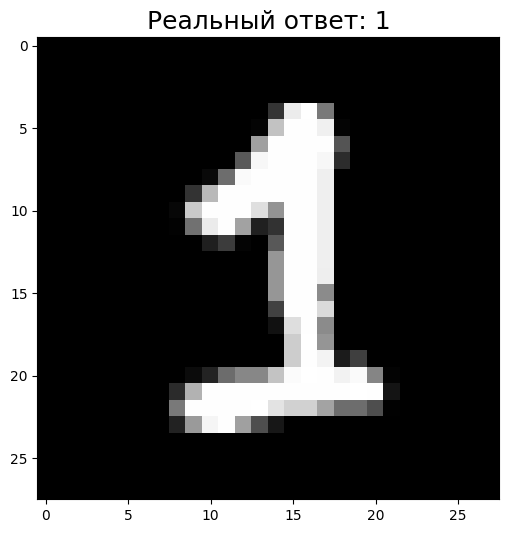

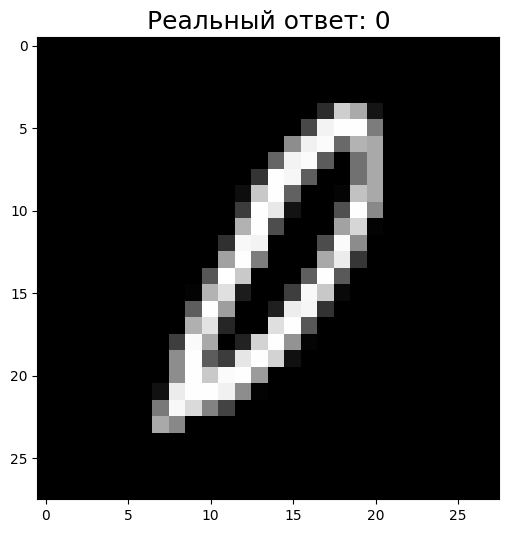

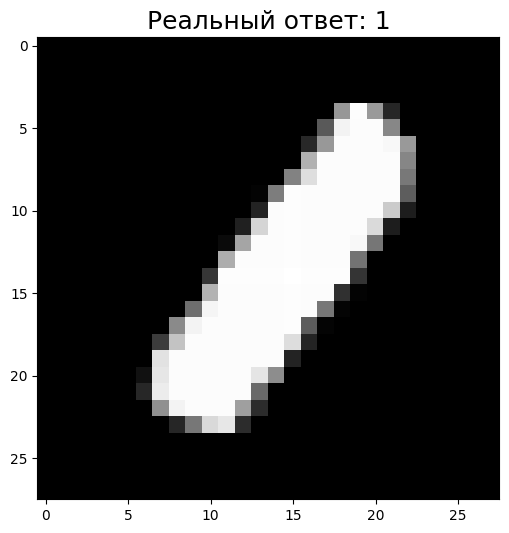

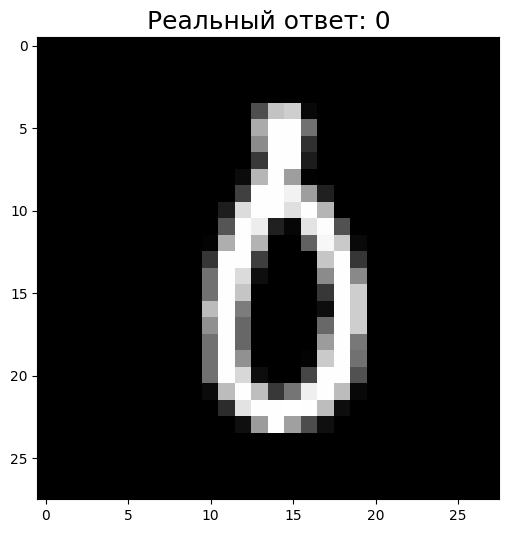

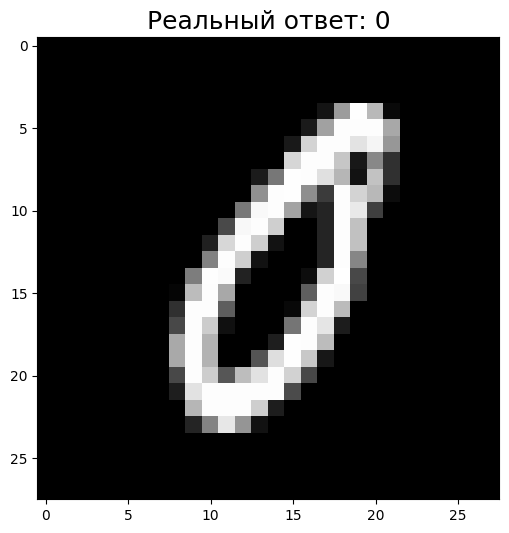

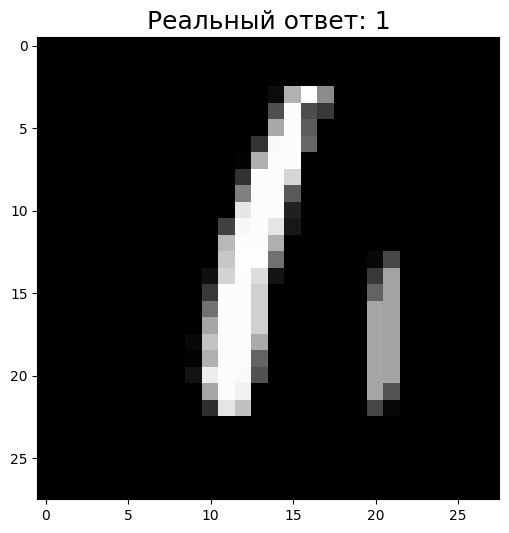

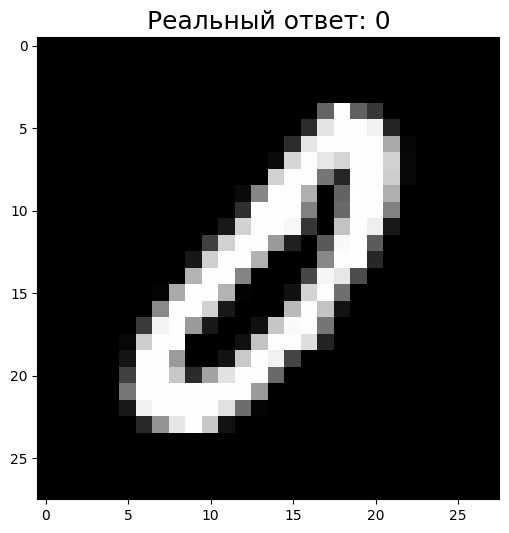

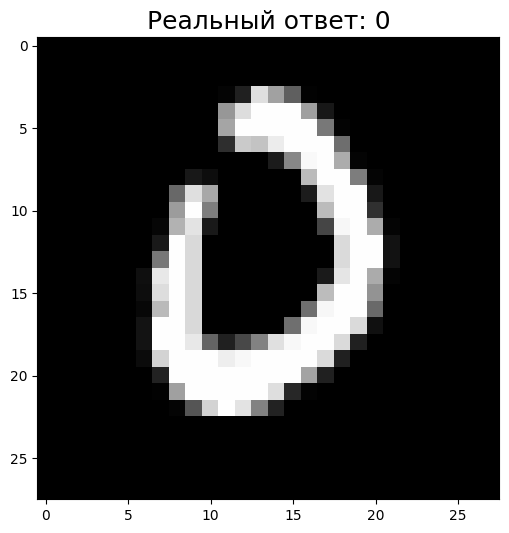

In [ ]:
import matplotlib.pyplot as plt

# картинки на которых зафейлилась нейронка
for wrong_id in np.where(real != preds)[0]:
    plt.figure(figsize=(6, 6))
    plt.title(f'Реальный ответ: {np.argmax(y_test[wrong_id])}', fontdict={'fontsize':18})
    plt.imshow(x_test[wrong_id].reshape((28, 28)), cmap='gray')